# EfficientDet : Scalable and Efficient Object Detection

## 1. Introduction

정확한 object detection을 위한 발전이 이루어지지만 그만큼 비용이 비싸지고 있다.<br>
큰 모델 사이즈와 비싼 계산비용으로 대기시간(latency)이 매우 제한된 로봇 공학 및 자율주행 자동차와 같은 <br>
application 배포를 하는데 어려움이 발생한다.<br>

one-stage, anchor-free detectors, 기존모델을 압축한것과 같은  <br>
효율적인 detercor architecture를 개발하는 것을 목표로 이전에 많은 작업들이 있었지만 <br>
efficiency를 높일수는 있으나 accuracy는 낮아지는 trade-off 현상이 발생한다. <br>
이 논문은 이를 해결하기 위한 근본적인 질문으로 <br>
> 광범위한 resource 제약(예: 3B ~ 300B FLOPs)에 걸쳐 더 높은 accuracy와 더 나은 efficiency을 모두 가진 scalable(확장가능한) detection architecture를 구축할 수 있는지에서 시작한다.<br>

<img src='https://drive.google.com/uc?export=download&id=1SkuvyySdQfeTzUUlXlT_3c5rwWSmnv6w' height="300" width="400">

- EfficientDet은 다른 detector보다
적은 parameter와 FLOP로 <br>
새로운 state-of-the-art 55.1% COCO AP를 달성한다.

### 1-1. efficient multi-scale feature fusion

- input feature map의 resoultion(해상도)가 다르기 때문에, <br>
결합된 output feature에 weight를 다르게 줘야한다.<br>
(이전까지는 feature map을 그대로 더해서(a:FPN) 같은 weight를 줬다)
- 이를 해결하기위해 간단하지만 효과적인 **bi-directional feature pyramid network(BiFPN)**을 제안한다.

<img src='https://drive.google.com/uc?export=download&id=11fkMQCvDyM9Dd2BflSHtVhaO4dTmvpI3' height="300" width="1000">

이전 detector은 backbone network의 pyramidal feature hierarchy를 기반으로 바로 수행된다.
- (a) FPN : top-down + multi-scale feature
- (b) PANet : FPN +  **extra bottom-up path**
- (c) NAS-FPN : 모델이 자동으로(AutoML) 찾아낸 **불규칙한 neural architecture**
>  GPU 사용하는데 많은 시간이 걸리고 불규칙한 feature들이 나오기때문에 모델을 설명하는데 어렵다.
- (d) BiFPN 
> input feature map들의 중요도에 따라 weight를 다르게 두는 학습가능한 weight이고,<br>
> 반복적으로 top-down, bottom-up하면서 multi-scale feature를 결합한다.
- 논문에서는 multi-scale feature fusion으로 최적화한다.

### 1-2. model scaling

- 정확도를 높이기위해 더 큰 backbone network를 사용하거나 input image size를 늘림으로써 <br>
baseline detector의 scale을 늘리는게 일반적인 방법인데 <br>
- 논문에서는 backbone, feature network, box/class prediction network에 대한 <br> 
resolution/depth(layer)/width(channel)를 scale up하는 <br>
compound scaling method를 사용한다. 이 방법 또한 정확도와 효율을 높인다.

- BiFPN로 만든 backbone efficientNet + compound scaling <br>
=> **efficientDet**

## 2. BiFPN

### 2-1. BiFPN이 나오게된 계기

  서로 다른 input feature들을 fusing하는 과정에서 기존 논문들은 input feature들에 대한 구분없이 단순히 더하는 방식을 취했다. 

  하지만 **input feature들은 서로 다른 resolution을 가지고 있어서 output feature를 생성하는데 미치는 영향 또한 같을 수는 없다.** 

  이에 대한 해결책으로 본 논문에서는 **input feature들의 서로 다른 importance**를 학습하는 learnable weights를 도입한 BiFPN (bi-directional feature pyramid network) 를 선택하였다.  

### 2-2. Problem Formulation

Multi-scale fusion의 목적은 서로 다른 resolution을 가진 feature들을 하나로 합치는것이다.

$\vec{P^{in}}$=($P_{l1}^{in}$,$P_{l2}^{in}$,...) 라는 multiscale있다고 하면
여기서 $P_{li}^{in}$는 level $l_{i}$에서의 feature를 의미한다. 

$\vec{P^{out}}=f(\vec{P^{in}}$)

이때 다른 features를 효과적으로 aggregate하는 transformation f를 찾는 것이 목표이다.


### 2-3. Cross-Scale Connections

#### FPN

- - -

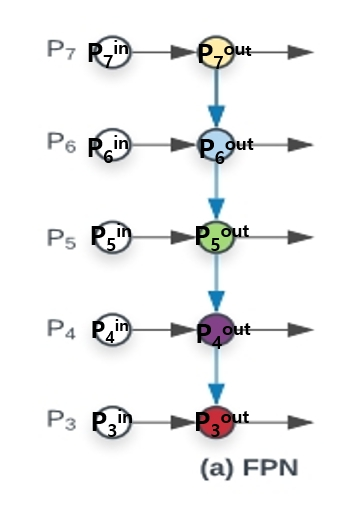

${P_{7}}^{out}$= Conv(${P_{7}}^{in}$)

${P_{6}}^{out}$= Conv(${P_{6}}^{in}$ + Resize(
${P_{7}}^{out}$))

$\cdots$ 


${P_{3}}^{out}$= Conv(${P_{3}}^{in}$ + Resize(
${P_{4}}^{out}$))

여기서 Resize 는 resolution matching을 위해 upsampling 혹은 downsampling을 하는것을 의미하고 Conv 는 convolutional operation을 뜻한다.



#### PANet

- - -

FPN에 bottom-up방식을 한번더 추가한것이다.
FPN과 NAS-FPN 보다 정확도는 높지만 더 많은 파라미터를가지고 있고 계산량도 많기 떄문에 효율성이 떨어진다.

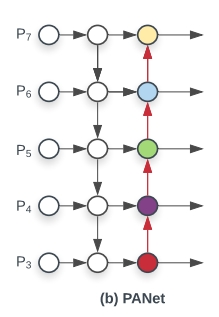

#### NAS-FPN

- - -

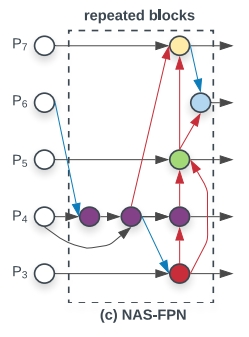

NAS-FPN에서는 아키텍쳐를 직접 설계하지 않고 neural architecture search를 통해 학습하는 방식을 사용하였으나 시간이 오래 걸리고 해석이나 수정하는데 있어 어려움이 있다는 단점이 있다.

#### BiFPN

- - -

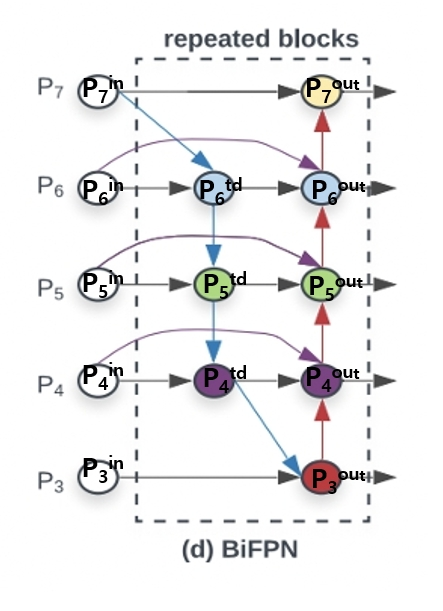

1. 단 한 개의 input edge를 갖는 node는 제거하였다. 제거한 이유는 단 한 개의 input edge를 가지는 node는 feature netowrk를 생성하는데 그다지 많은 영향을 끼치지 않기 때문이다.


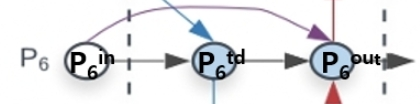

2. 더 많은 feature fusion을 하기 위해 보라색 엣지를 추가해주었다.

3. repeated blocks를 반복하여 high-level feature fusion이 가능하게 해주었다.

### 2-4. Weighted Feature Fusion

- - -

  이전 방법들은 구분없이 모든 input features들을 다룬다. 하지만 다른 input features는 다른 resolution(해상도)를 가지고있기 때문에 output feature들을 똑같이 다루면 안된다. 따라서 각각의 input 값에 추가적인**가중치**를 적용하여서 각각의 **input feature의 중요도를 네트워크가 학습하게 한다.** 

#### Unbounded fusion

- --

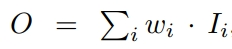

학습가능한 가중치 w는 feature당 scalar값,channel당 vetor값 또는  pixel당 다차원tensor값이 될수있다. 작은 계산 비용으로 상대적으로 좋은 정확성을 가질수있지만  scalar 가중치는 트레이닝시키는것에 있어서 불안정함을 유발할 수 있다(w값이 무한대로 커지거나 작아질수있다).

> 따라서 각각의 가중치에 범위를 정해서 가중치값을 정규화해야된다.

#### Softmax-based fusion

- - -

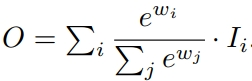

Softmax를 사용하면 범위가 0과1사이로 가각의 input feature에 중요도에 따른 모든 가중치를 정규화할 수 있다.

하지만 softmax는 계산량이 너무많아서  GPU 하드웨어의 속도를 크게 저하시킨다.

#### Fast normalized fusion

- - -

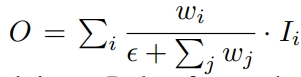

각각의 가중치는 Relu함수를 적용한 후이기 때문에 $w_{i}$$\geq$0 이 보장되어있다.따라서 Fast normalized fusion식에서 분모의 값이 0이되는것을 막기위하여
$\epsilon$ = 0.0001를 더해준다. Softmax-based fusion과 마찬가지로정규화된 가중치는 모두 0과1사이가 될 뿐 만아니라 훨씬 효율적이다.

### 2-5. BiFPN concrete example

BiFPN는 bidirectional cross-scale connections 과 fast normalized fusion의 합이다. 

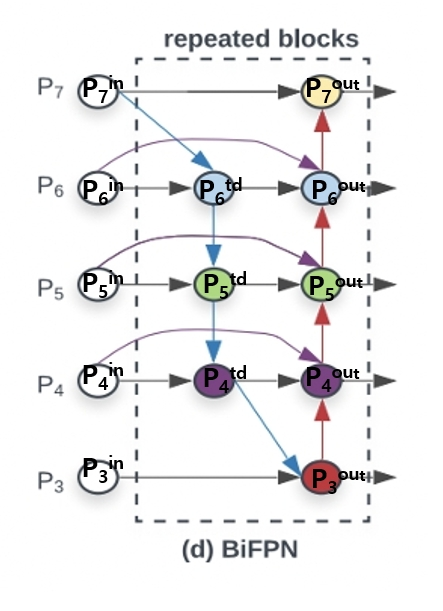

### ${P_{6}}^{td}$= Conv($\frac{w_{1} ·{P_{6}}^{in}+w_{2}·Resize({P_{7}}^{in})}{w_{1}+w_{2}+\epsilon}$)

### ${P_{6}}^{out}$= Conv($\frac{w_{1}' ·{P_{6}}^{in}+ w_{2}' ·{P_{6}}^{td}    +w_{3}'·Resize({P_{5}}^{out})}{w_{1}'+w_{2}'+w_{3}'+\epsilon}$)

효율성을 향상시키기위해 depthwise separable convolution을 하고 각각의 convolution을 시행한후에 batch normalization과 activation을한다.

->convolution을 할때 depthwise separable convolution를 하게되면 기존의 convolution보다 파라미터수와 연산량이 훨씬적어서 효율성이 향산된다.

#### depthwise separable convolution

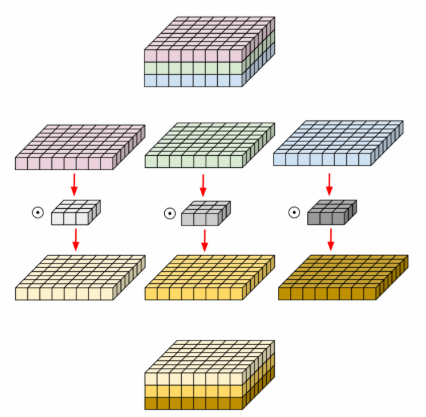

 H* W *C의 conv output을 C(channel)단위로 분리하여 각각 conv filter을 적용하여 output을 만들고 그 결과를 다시 합치면 <br>
 conv filter가 훨씬 적은 파라미터를 가지고서 동일한 크기의 아웃풋을 낼 수 있다.

## 3. EfficientDet
- BiFPN에 기초하여, 저자들은 EfficientDet이라는 새로운 detection 모델을 만들었다. <br>
EfficientDet의 네트워크 구조와 새로운 compound scaling 메소드를 알아보자.


### 3-1. EfficientDet Architecture

<img src='https://drive.google.com/uc?export=download&id=1x4PLl8jui5iEmxTxYgY-vbwu7A0DUZTl' height="330" width="900"> 

EfficientDet의 전체적인 구조는 위 이미지와 같다. <br>
그동안의 one-stage detector들의 패러다임을 모두 따랐고 SSD,FPN,YOLO,Focal Loss 내의 모든 개념을 포함시켰다. <br>
* Backbone 네트워크로는 ImageNet으로 사전훈련된 EfficientNet을 사용했다. <br>
* Feature Network에는 앞에 소개된 BiFPN을 적용하였고 이것으로 Backbone에서 {$P_3,P_4,P_5,P_6,P_7$} 피쳐맵을 추출해낸다. <br>
(BiFPN에선 반복적인 top-down과 bottom-up을 통해 피쳐들을 합친다 (Feature Fusion))
* 이 피쳐맵들은 Focal Loss에서 사용했던것과 같은 head에 전달되고 각각 class subnet, box subnet을 통해 예측을 한다.

### 3-2. Compound Scaling

저자들은 정확성과 효율성 모두 최적화하는 것을 목표로 하여 <br>
광범위한 컴퓨팅 리소스 제약조건을 충족할 수 있는 모델을 개발하고자 했다. <br>
핵심 목표는 baseline인 EfficientDet model을 어떻게 스케일업 하느냐였다. <br>
그동안 인풋 이미지의 크기를 키우거나, 더욱 깊은 backbone 네트워크를 구성하는 등 <br> 기존 연구에서 스케일 업을 시도했으나 대부분 단일, 혹은 제한된 dimention만을 스케일업하여 효용성이 떨어졌다. <br>
하지만 최근 이미지 classification에서 연구된 [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf)은 <br>
width, depth, input resolution 모두를 적절한 비율로 동시에 스케일업(compound scaling)함으로써 놀라운 효율성을 보여줬다. <br>

> 이 연구에 영감을 받아 저자들은 object detection에서도 적용가능한 새로운 compound scaling방법을 제안한다. <br>
간단한 compound coefficient $ϕ$를 사용하여 __Backbone, BiFPN, class/box network, resolution__ demension 모두를 스케일업한다. <br>

object detection의 demension은 너무 많기 때문에 grid search대신 휴리스틱 접근법을 사용했다. <br>

<img src='https://drive.google.com/uc?export=download&id=1fcaSPrbps2j-a-NKwwckbiEWLufSXRT3' height="330" width="900"> 

#### Backbone network

<img src='https://drive.google.com/uc?export=download&id=1WhQm3vIPgduipdeF_dw7qa4IrEHDiB-Z' height="150" width="350"> <br>
<EfficientNet의 compound scaling method>

저자들은 EfficientNet의 B0부터 B6까지의 똑같은 width/depth 스케일링 계수(coefficient)를 사용했다. <br>
이것으로 ImageNet으로 사전훈련된 checkpoint들을 손쉽게 재사용할 수 있다. <br>

#### BiFPN network

> (1)  $D_{bifpn} = 3 + ϕ $

BiFPN의 Depth(#layers)는 정수로 맞춰줘야하기때문에 linear하게 증가시켰다. <br>

> (1) $W_{bifpn} = 64·(1.35^ϕ)$

BiFPN의 Width(#chnnels)는 EfficientNet과같이 exponential하게 증가시켰다. <br>
저자들은 {$1.2, 1.25, 1.3, 1.35, 1.4, 1.45$} 의 값들 모두 grid search를 통해, $1.35$ 라는 최적의 값을 찾았고 이것을 scaling factor로 사용했다.

#### Box/Class prediction network

<img src='https://drive.google.com/uc?export=download&id=1Wj-5cuDS1xu1UUGxN8j6a3FZUvoSOnAQ' height="400" width="530"> 

> (2) $W_{pred} = W_{bifpn}$

> (2) $D_{box} = 3 + |\frac{ϕ}{3}|$

[Focal Loss](https://arxiv.org/pdf/1708.02002.pdf) 논문의 RetinaNet에서 사용한 box/class predictor(convolution 구조)를 사용했고, <br>
width(#channels)는 BiFPN과 동일하게 증가시킨다. <br>
Depth(#layers)는 위의 식과같이 linear하게 증가시켰다.

#### Input Image resolution

> (3) $R_{input} = 512 + ϕ·128 $

BiFPN의 피쳐맵을 사용하기때문에 이미지 해상도는 128로 나누어질수있어야한다. <br>
따라서 위와같은 식으로 linear하게 증가시켰다. <br>

<img src='https://drive.google.com/uc?export=download&id=1GVgPefAQ28rkj8NnkzLQ9JQrHAFSARFk' height="350" width="900"> <br>
> Backbone의 width와 depth, <br>
BiFPN의 width와 depth, <br>
box/class predictor의 width와 depth, <br>
인풋 이미지 resolution 모두를 스케일업 한다.

## 4. Experiments

<img src='https://drive.google.com/uc?export=download&id=1Sa3nWe62REBn9WpQoWV_ug4zoDqKBeBq' height="300" width="530"> 

(1),(2),(3) 의 수식들과 각기다른 계수 $ϕ$를 사용하여, <br>
저자들은 $D0(ϕ=0)$부터 $D7(ϕ=7)$까지의  __EfficientDet__을 개발했다. <br>
D7과 D7x는 같은 BiFPN을 가지고있지만 D7이 더 큰 해상도를 사용하고 <br>
D7x는 더 큰 backbone 네트워크을 사용하고 P3부터 P8까지 피쳐맵 하나를 더 갖는다. <br>

<img src='https://drive.google.com/uc?export=download&id=1KeNthPmMksv1ai199LA4Y1WKKgB9TzCM' height="370" width="500"> 

- B0~B7 : efficientNet의 **input resolution과 channel, layer**에 따른 baseline <br>
> <img src='https://drive.google.com/uc?export=download&id=1BJgRalr1nXYjEpmn20-Lqx9Jbu67r5Ou' height="350" width="500">

### 모델간 성능 평가

<img src='https://drive.google.com/uc?export=download&id=1A3PjaZ5cvA8phVCrse4A2GcduSR91znF' height="600" width="900">

Table2는 efficientDet과 다른 모델과 비교한 것인데 <br> 
efficientDetD0이 28배 더 적은 FLOP로 YOLO-v3과 유사한 accuracy를 달성한다.<br>

retinanet 및 mask-RCNN과 비교했을때, <br>
EfficientDetD1,D2는 최대 8배 적은 parameter와 21배 적은 FLOP로 유사한 정확도를 달성한다.

> **EfficientDet은 다른 모델에 비해 parameter(Params)의 수와 FLOP가 적어 보다 효율적이다.** <br>

<img src='https://drive.google.com/uc?export=download&id=1-wGp19Zk6qQoCX4ahIzDwkinxquH10Kd' height="400" width="1000"> <br>
> EfficientDet 모델은 GPU에서 최대 4.1배, CPU에서 10.8배
더 빠르다.

## 5. Conclusion
- 논문에서는 효율적인 object detection을 위해 network architecture를 선택하고 정확도와 효율성을 향상시키기 위해 <br> **BiFPN와 맞춤형 compound scaling 방법**을 제안한다.
- 이러한 optimization를 기반으로 **EfficientDet**을 개발하고 더 나은 accuracy과 efficiency를 달성한다. 
- 특히, scale된 EfficientDet는 이전의 object detection 모델보다 훨씬 적은 paramter와 FLOP로 state-of-the art accuracy를 달성한다.